In [1]:
from pathlib import Path
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import xarray as xr
import iris
import iris.plot
import numpy as np
import os
import sys
import textwrap
import itertools
import ants
import warnings

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/ants/regrid/esmf.py:26: UserWarning:  No module named 'ESMF'
Proceeding without capabilities provided by ESMPy (ESMF).
  warnings.warn(msg.format(str(_ESMF_IMPORT_ERROR)))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/ants/regrid/_ugrid.py:19: UserWarning:  No module named 'ESMF'
Proceeding without capabilities provided by ESMPy (ESMF).
  warnings.warn(msg.format(str(_ESMF_IMPORT_ERROR)))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/iris/experimental/raster.py:29: IrisDeprecation: iris.experimental.raster is deprecated since version 3.2, and will be removed in a future release. If you make use of this functionality, please contact the Iris Developers to discuss how to retain it (which may involve reversing the deprecation).
  warn_deprecated(wmsg)


In [2]:
# Change to your local repo path
sys.path.append('/g/data/gb02/pag548/UM_config_tools/UM_config_tools')

from plot_ancillaries import plot_ancils, collapse_cube

home_dir=os.environ['HOME']
HOME=Path(home_dir)

In [3]:
# Find all regions for a given rose-id
ROSE ='u-dq487'
REGION_DIRS = [ d for d in list((HOME / 'cylc-run' / ROSE / 'share/data/ancils/' ).glob('*')) if d.is_dir() ]
REGION_DIRS                                                           

[PosixPath('/home/548/pag548/cylc-run/u-dq487/share/data/ancils/Flagship_ERA5to1km')]

In [4]:
# Find all resolutions for a given REGION
for r_dir in REGION_DIRS:
    RESOLUTION_DIRS = [ d for d in list((r_dir).glob('*')) if d.is_dir() ]

In [5]:
RESOLUTION_DIRS

[PosixPath('/home/548/pag548/cylc-run/u-dq487/share/data/ancils/Flagship_ERA5to1km/1km-WC'),
 PosixPath('/home/548/pag548/cylc-run/u-dq487/share/data/ancils/Flagship_ERA5to1km/5km'),
 PosixPath('/home/548/pag548/cylc-run/u-dq487/share/data/ancils/Flagship_ERA5to1km/12km'),
 PosixPath('/home/548/pag548/cylc-run/u-dq487/share/data/ancils/Flagship_ERA5to1km/12km-halo')]

Plotting land_binary_mask for 1km-WC with shape (2112, 2000)
Plotting land_binary_mask for 5km with shape (976, 1466)
Plotting land_binary_mask for 12km with shape (580, 780)
Plotting land_binary_mask for 12km-halo with shape (600, 800)


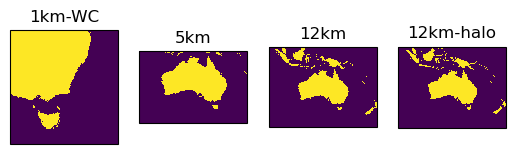

In [6]:
# quick check - plot and store land-sea masks for these resolutions
# Ignore warnings from mule  and iris 
warnings.filterwarnings('ignore',module='mule') 
warnings.filterwarnings('ignore',module='iris') 

num_plots = len(RESOLUTION_DIRS)

lsm_masks = {}

fig,ax = plt.subplots(1,num_plots,subplot_kw={'projection': ccrs.PlateCarree()})

for i,R in enumerate(RESOLUTION_DIRS):
    MASK_FILE = R / 'qrparm.mask'
    mask_cubes = ants.load(MASK_FILE)

    # Select the cube corresponding to 'land_binary_mask'
    lbm_cube, = [ cube for cube in mask_cubes if cube.name() == 'land_binary_mask'] 
    print (f'Plotting land_binary_mask for {R.name} with shape {lbm_cube.shape}')
    
    iris.plot.pcolormesh(lbm_cube,axes=ax[i])
    ax[i].set_title(f'{R.name}')

    # Store the masks for later analysis
    lsm_masks[R.name] = xr.DataArray.from_iris(lbm_cube)

In [7]:
# Check extents of the LSM
for key in lsm_masks.keys():
    print (f'{key} has bounds {lsm_masks[key].latitude.min().values:.2f}',
       f'{lsm_masks[key].latitude.max().values:.2f}',
       f'{lsm_masks[key].longitude.min().values:.2f}', 
       f'{lsm_masks[key].longitude.max().values:.2f}') 

1km-WC has bounds -46.07 -27.08 140.03 158.02
5km has bounds -51.91 -8.03 100.04 165.97
12km has bounds -56.76 6.93 90.13 175.82
12km-halo has bounds -57.86 8.03 89.03 176.92


In [8]:
# Now create dictionaries for all ancillary parameter files for each resolution
parm_files = {}

for i,R in enumerate(RESOLUTION_DIRS):
    
    all_files = list(R.glob('qrparm*'))

    # Filter out symlinks
    files = []
    [ files.append(f) for f in all_files if not f.is_symlink() ]

    parm_files[R.name] = files

In [9]:
# Get total list of fields for each resolution
num_plots = {}

# Loop over LAM resolutions
for res in parm_files.keys():

    count = 0
    # Loop over each ancillary parameter file for this resolution
    for file in parm_files[res]:
        #print (f'INFO : Loading {file}')
        try:
            cube = ants.load(file)
            #print (cube)
            count += len(cube)
        except:
            print (f'ERROR : Unable to open {file}\nERROR : You will have to manually check this file using "xconv" ')
            continue

    num_plots[res] = count
    print (f'There are {num_plots[res]} fields for {res}')
    

ERROR : Unable to open /home/548/pag548/cylc-run/u-dq487/share/data/ancils/Flagship_ERA5to1km/1km-WC/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 97 fields for 1km-WC
ERROR : Unable to open /home/548/pag548/cylc-run/u-dq487/share/data/ancils/Flagship_ERA5to1km/5km/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 72 fields for 5km
ERROR : Unable to open /home/548/pag548/cylc-run/u-dq487/share/data/ancils/Flagship_ERA5to1km/12km/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 72 fields for 12km
ERROR : Unable to open /home/548/pag548/cylc-run/u-dq487/share/data/ancils/Flagship_ERA5to1km/12km-halo/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 72 fields for 12km-halo


 Plotting ancillary parameters for 12km-halo

For qrparm.veg.func_igbp canopy_height coordinate pseudo_level will be collapsed
For qrparm.veg.func_igbp canopy_height coordinate month will be collapsed
For qrparm.veg.func_igbp leaf_area_index coordinate pseudo_level will be collapsed
For qrparm.veg.func_igbp leaf_area_index coordinate month will be collapsed
For qrparm.veg.func canopy_height coordinate pseudo_level will be collapsed
For qrparm.veg.func variable canopy_height coordinate time will be collapsed
ERROR : NaNs identified in canopy_height,qrparm.veg.func
For qrparm.veg.func leaf_area_index coordinate pseudo_level will be collapsed
For qrparm.veg.func variable leaf_area_index coordinate time will be collapsed
ERROR : Unable to open /home/548/pag548/cylc-run/u-dq487/share/data/ancils/Flagship_ERA5to1km/12km-halo/qrparm.veg.dist
For qrparm.veg.frac.urb2t m01s00i216 coordinate pseudo_level will be collapsed
For qrparm.veg.frac_igbp m01s00i216 coordinate pseudo_level will be collap

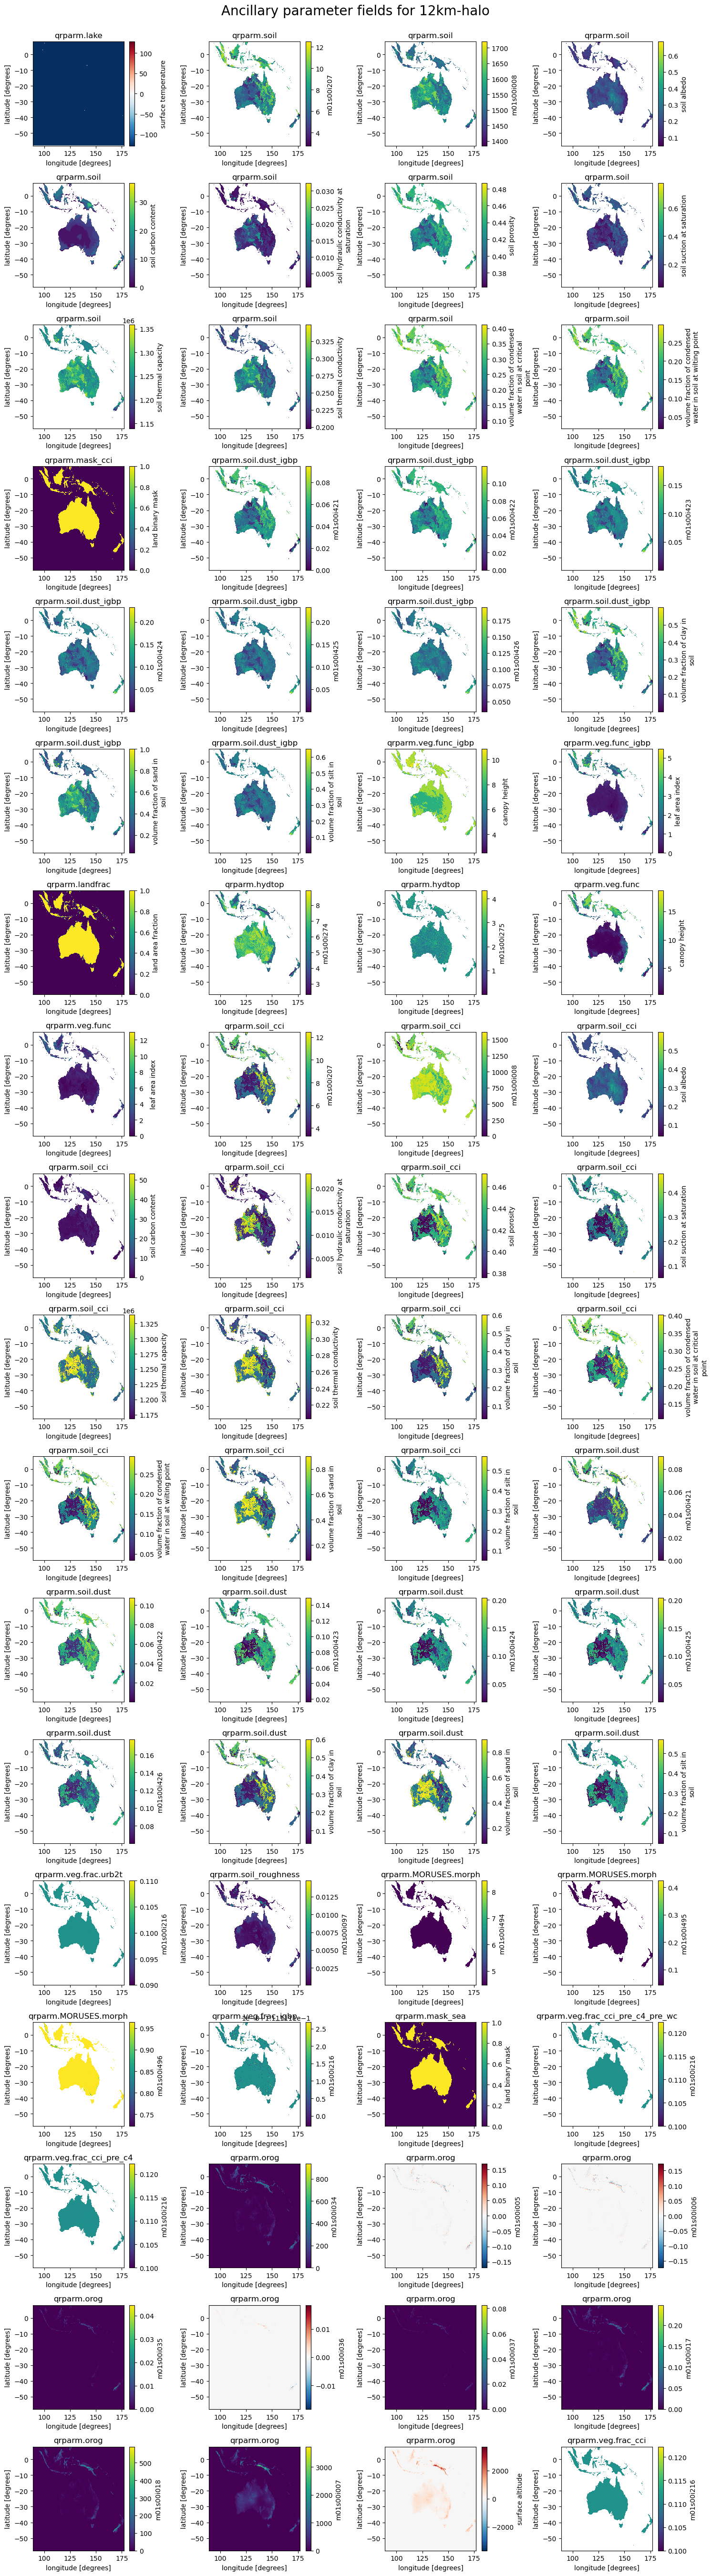

In [10]:
# Now plot for all resolutions and catch ancillary parameter fields with NaNs
bad_ancils = []

# Loop over all resolutions
#for res in parm_files.keys():
for res in ['12km-halo']:
    nan_ancils = plot_ancils(res,
                             parm_files[res],
                             lsm_masks[res],
                             num_plots[res])

    bad_ancils.extend(nan_ancils)

In [17]:
# Zoom in on NaNs. Let's do this manually for region 12-halo  
# These ancils have a land-sea mask so we need to extract that
if bad_ancils:
    da = bad_ancils[0][0]
    mask = lsm_masks['12km-halo']
    
    all_mask = mask & da.isnull()
    
    # Find location of NaNs
    all_mask.compute()
    all_mask.where(all_mask.compute()==True,drop=True).compute()

In [20]:
points = all_mask.where(all_mask.compute()==True,drop=True).compute()

In [21]:
points

<xarray.DataArray (latitude: 1, longitude: 1)> Size: 8B
array([[1.]])
Coordinates:
  * latitude      (latitude) float32 4B -54.56
  * longitude     (longitude) float32 4B 158.9
    pseudo_level  int64 8B 3
    time          datetime64[ns] 8B 2005-07-02T12:00:00

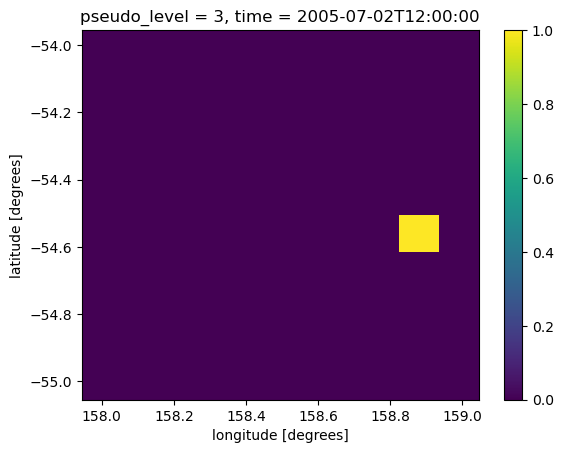

In [22]:
all_mask.sel(latitude=slice(-55,-54),longitude=slice(158,159)).plot()

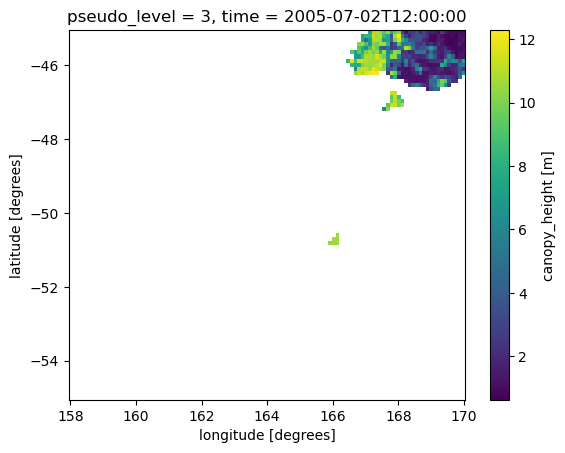

In [31]:
da.sel(latitude=slice(-55,-45),longitude=slice(158,170)).plot()

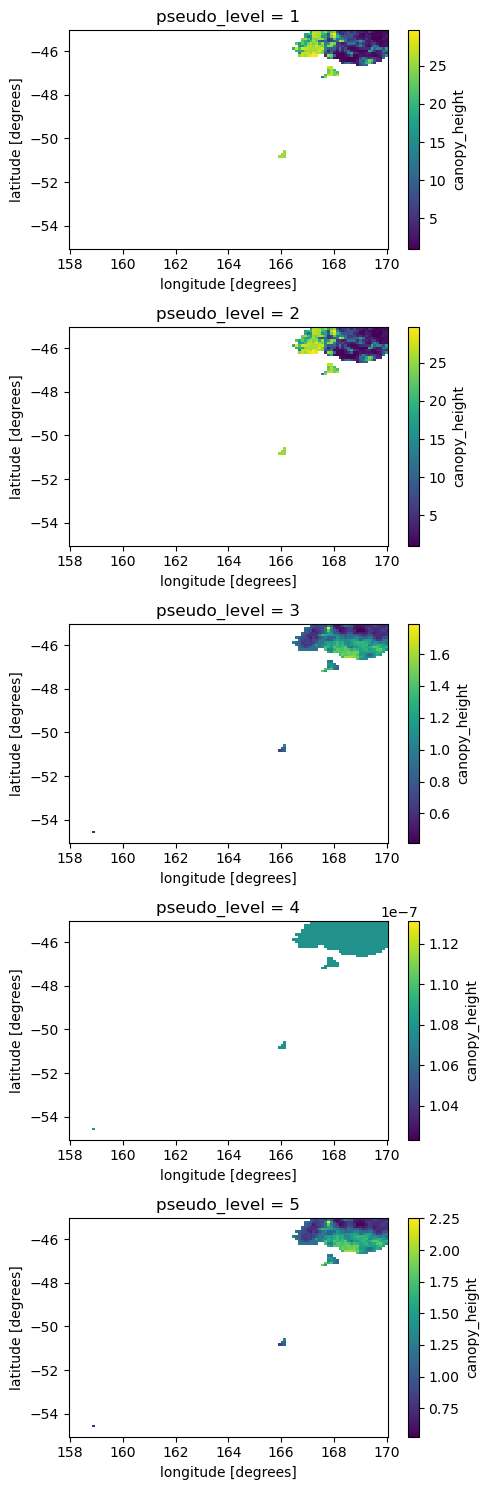

In [34]:
veg_cubes = ants.load ( REGION_DIRS[0] / '12km-halo/qrparm.veg.func')
canopy_cube, = [ cube for cube in veg_cubes if cube.name() == 'canopy_height' ]
canopy_height = xr.DataArray.from_iris(canopy_cube)

fig,ax=plt.subplots(5,1,figsize=(5,15))

for level in canopy_height.dim_0:
    da = canopy_height.sel(dim_0=level,latitude=slice(-55,-45),longitude=slice(158,170)).\
         mean('time').plot(ax=ax.flatten()[level])
plt.tight_layout()

In [ ]:

cubes = ants.load(file)

for cube in cubes:

    if len(cube.shape) > 2: 
        # Need to reduce dimension
        cube = collapse_cube(file,cube)
        
    da = xr.DataArray.from_iris(cube)

    # Find NaNs
    all_mask = da.isnull()
    #print (da.attrs.keys())

    if 'standard_name' in da.attrs.keys():
        split = textwrap.wrap(da.attrs['standard_name'].replace('_',' '),max_label_length)
        label = '\n'.join(split)
        cb_args = {'label': label}
    else:
        cb_args = {'label':da.attrs['STASH']}
        cb_string = f"{da.attrs['STASH']}"
        print (cb_string)
        print (len(cb_string))

In [ ]:
print (f"DEBUG: {cube} {da.attrs['STASH']}")
print (f"DEBUG: {cube} {len(da.attrs['STASH'])}")

In [ ]:
# Now plot for all resolutions and catch ancillary parameter fields with NaNs
bad_ancils = []

# Loop over all resolutions
#for res in parm_files.keys():
for res in ['12km-halo']:
    nan_ancils = plot_ancils(res,
                             parm_files[res],
                             lsm_masks[res],
                             num_plots[res])

    bad_ancils.extend(nan_ancils)

In [ ]:
da.attrs

In [ ]:
# Now plot the bad_ancils
if bad_ancils:
    num_plot=len(bad_ancils)
    num_columns=3
    num_rows = num_plot // num_columns
    
    if num_plot % num_columns != 0:
        num_rows += 1
    
    Position = range(1,num_plot+1)
    
    fig_height = num_rows*3
    fig_width = 15
    max_label_length=30
    
    fig = plt.figure(figsize=(fig_width,fig_height))
    
    k = 0
    
    for k in range(num_plot):
         ax = fig.add_subplot(num_rows, num_columns, Position[k])
         da = bad_ancils[k]
         da.plot(ax=ax)
         ax.set_title(f'{da.name}')
    plt.tight_layout()

In [ ]:
# Now plot for all resolutions and catch ancillary parameter fields with NaNs
bad_ancils = []

# Loop over all resolutions
#for res in parm_files.keys():
for res in ['1km']:
    nan_ancils = plot_ancils(res,
                             parm_files[res],
                             num_plots[res])

    bad_ancils.extend(nan_ancils)

In [ ]:
# Now plot for all resolutions and catch ancillary parameter fields with NaNs
bad_ancils = []

# Loop over all resolutions
#for res in parm_files.keys():
for res in ['5km']:
    nan_ancils = plot_ancils(res,
                             parm_files[res],
                             num_plots[res])

    bad_ancils.extend(nan_ancils)

In [ ]:
# Repeat for 1 km domain
# Now plot for all resolutions and catch ancillary parameter fields with NaNs
bad_ancils = []

# Loop over all resolutions
#for res in parm_files.keys():
for res in ['1km']:
    nan_ancils = plot_ancils(res,
                             parm_files[res],
                             num_plots[res])

    bad_ancils.extend(nan_ancils)

In [ ]:
# Zoom in on NaNs. Let's do this manually for region 1km 
# These ancils have a land-sea mask so we need to extract that
if bad_ancils:
    da = bad_ancils[0]
    mask = lsm_masks['1km']
    
    all_mask = mask & da.isnull()
    
    # Find location of NaNs
    all_mask.compute()
    all_mask.where(all_mask.compute()==True,drop=True).compute()

In [ ]:
# OK, so we seem to have three points of NaN located b/w lat -54.7 to -52.6
# lat 158.9 to 169.2
da.sel(latitude=slice(-55,-45),longitude=slice(158,170)).plot()


In [ ]:
# So we are in the Southern Ocean. Let's plot the bad points
points = all_mask.where(all_mask.compute()==True,drop=True).compute()

In [ ]:
all_mask.sel(latitude=slice(-55,-45),longitude=slice(158,170)).plot()

In [ ]:
# These points appear to be associated with Macquarie Island and Campbell Island.
# Let's plot all the ERA5 ancillaries around Macquarie Island.
all_mask.sel(latitude=slice(-55,-54),longitude=slice(158,159)).plot()

In [ ]:
res='era5'
nan_ancils = plot_ancils(res,
                         parm_files[res],
                         num_plots[res],
                         lat_range=[-55,-54],
                         lon_range=[158,159])

In [ ]:
# Repeat for Cambpell Island
all_mask.sel(latitude=slice(-53,-52),longitude=slice(168.5,169.5)).plot()

In [ ]:
res='era5'
nan_ancils = plot_ancils(res,
                         parm_files[res],
                         num_plots[res],
                         lat_range=[-53,-52],
                         lon_range=[168.5,169.5])

In [ ]:
# Same issue for Macquarie Island - the canopy height fields are missing

In [ ]:
# OK. So Macquarie Island is resolved at this resolution for all ancillaries except canopy height.
#  And the island is resolved by qrparm.mask_cci (which is the file used by the UM).
#  The island isn't resolved by qrparm.mask_sea however.
# Let's use the method suggested by Matthew Lipson : https://forum.access-hive.org.au/t/aus2200-vegetation-fraction-ancil-creation-issues/1972/13?u=paul.gregory
veg_func_file, = [ f for f in parm_files['era5'] if f.name == 'qrparm.veg.func' ]
lsm_mask_file,  = [ f for f in parm_files['era5'] if f.name == 'qrparm.mask_cci' ]

In [ ]:
veg_cube = ants.load(veg_func_file)[0]
lsm_cube = ants.load(lsm_mask_file)[0]

In [ ]:
level=3
canopy_level = iris.Constraint(pseudo_level=level)

In [ ]:
veg_cube.extract(canopy_level)

In [ ]:
veg_cube.coords()

In [ ]:
# Use time constraints
# https://gist.github.com/dennissergeev/58a04be5fdfe37cedea838a19203e75e
tcoord = veg_cube.coord("time")
time_constr = iris.Constraint(time=lambda t: t.point == tcoord.units.num2date(tcoord.points[0]))
veg_slice=veg_cube.extract(time_constr).extract(canopy_level)

In [ ]:
veg_slice

In [ ]:
# Plot veg_slice around the southern ocean:
fig=plt.figure()
iris.plot.pcolormesh(veg_slice.intersection(latitude=(-55,-45),longitude=(158,170)))
plt.colorbar()

In [ ]:
veg_cube.extract(canopy_level)

In [ ]:
canopy_height = xr.DataArray.from_iris(veg_cube)
canopy_height

In [ ]:
fig,ax=plt.subplots(5,1,figsize=(5,15))

for level in canopy_height.dim_0:
    da = canopy_height.sel(dim_0=level,latitude=slice(-55,-45),longitude=slice(158,170)).\
         mean('time').plot(ax=ax.flatten()[level])
plt.tight_layout()

In [ ]:
# To do - interrrogate the master data ancillary to see if the data is missing at these levels
master_lai = Path('/home/548/pag548/cylc-run/u-dg767/share/data/etc/ancil_master_cap/vegetation/lai/modis_4km/v1/qrparm.data')
master_lai_cube, = ants.load(master_lai)
tcoord = master_lai_cube.coord("time")
time_constr = iris.Constraint(time=lambda t: t.point == tcoord.units.num2date(tcoord.points[0]))

In [ ]:
master_lai_da = xr.DataArray.from_iris(master_lai_cube)
master_lai_da[0]

In [ ]:
master_lai_da[0].plot()

In [ ]:
master_lai_da[0].sel(latitude=slice(-55+180,-45+180),longitude=slice(158,170)).plot()

In [ ]:
master_canopy = Path('/home/548/pag548/cylc-run/u-dg767/share/data/etc/ancil_master_cap/vegetation/canopy/simard/v1/Simard_Pinto_3DGlobalVeg_JGR.nc')
master_canopy_cube, = ants.load(master_canopy)
master_canopy_cube

In [ ]:
master_cover = Path('/home/548/pag548/cylc-run/u-dg767/share/data/etc/ancil_master_cap/vegetation/cover/igbp/v3/gigbp2_0ll.nc')
master_cover_cube, = ants.load(master_cover)

In [ ]:
# Repeat of u-cp146

In [ ]:
orog = iris.load(RESOLUTION_DIRS[0]/'qrclim.sslt.nc')

In [ ]:
orog

In [ ]:
iris.plot.pcolormesh(orog[0][0][0])

In [ ]:
orog